In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

data = https://catalog.data.gov/dataset/crimes-2001-to-present-398a4

In [4]:
data = pd.read_csv("Crimes_-_2001_to_present.csv")
data.dropna(inplace=True)
data = data.loc[(data['Primary Type'] == "THEFT")]
data["Date"] = data["Date"].str[:10]
days = np.unique(data["Date"].values).tolist()
days.sort(key = lambda date: datetime.strptime(date, "%m/%d/%Y"))
data = data[data.Latitude != 36.619446395]
data.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,8,9,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
62615,11622422,JC183696,03/12/2019,008XX E 38TH PL,0820,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),False,False,...,4.0,36.0,06,1182276.0,1879784.0,2019.0,08/17/2019 03:57:45 PM,41.825347,-87.6068,"(41.825346902, -87.606780575)"
63349,11661997,JC228271,04/17/2019,034XX W ARMITAGE AVE,0820,THEFT,$500 AND UNDER,PARKING LOT/GARAGE(NON.RESID.),False,False,...,26.0,22.0,06,1153253.0,1913079.0,2019.0,08/17/2019 03:57:45 PM,41.917336,-87.7124,"(41.917336159, -87.712375085)"
63381,11662440,JC231024,04/18/2019,026XX W FULLERTON AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,...,1.0,22.0,06,1158218.0,1915850.0,2019.0,08/17/2019 03:57:45 PM,41.924840,-87.6941,"(41.924839894, -87.69405765)"
63489,11663358,JC232931,04/21/2019,052XX N NASHVILLE AVE,0810,THEFT,OVER $500,RESIDENCE-GARAGE,False,False,...,45.0,10.0,06,1131583.0,1934489.0,2019.0,08/17/2019 03:57:45 PM,41.976491,-87.7915,"(41.976490526, -87.791494995)"
63553,11667017,JC237342,04/25/2019,016XX N WESTERN AVE,0820,THEFT,$500 AND UNDER,CTA TRAIN,False,False,...,1.0,24.0,06,1160111.0,1910846.0,2019.0,08/17/2019 03:57:45 PM,41.911070,-87.6872,"(41.911069617, -87.687240439)"


In [5]:
max_lat = data['Latitude'].max()
min_lat = data['Latitude'].min()
max_lon = data['Longitude'].max()
min_lon = data['Longitude'].min()
print(min_lat,max_lat,min_lon,max_lon)

41.644589713 42.022671246 -87.934272688 -87.524529465


In [6]:
years = list(map(int, data.Year.unique().tolist()))
years.sort()
n_years = len(years)
listDates = [[] for x in range(n_years)]
dataPartitioned = [[] for x in range(n_years)]


def create_year_x(year, days):
    """Makes a list with the days of the dataset with a specific year"""
    List = []
    n_days = len(days)
    for i in range(n_days):
        if (int(days[i][-4:]) == year):
            List.append(days[i])
    return List

for i in range(n_years):
    listDates[i] = create_year_x(years[i], days)
    dataPartitioned[i] = data.loc[data['Year'] == years[i]]

In [7]:
def creatematrices(days, data, n_rc):
    """Makes matrices of n_rc x n_rc shape using a list of days and a dataframe"""
    X = []
    n_days = len(days)
    matrix = np.zeros(shape=(n_rc,n_rc))
    n_sum_lat = (max_lat-min_lat)/n_rc
    n_sum_lon = (max_lon-min_lon)/n_rc
    for k in range (n_days):
        dayk = data.loc[(data['Date'] == days[k])]
        matrix_aux = matrix
        start_lon = min_lon
        end_lon = min_lon + n_sum_lon
        for i in range (n_rc):
            start_lat = min_lat
            end_lat = min_lat + n_sum_lat
            for j in range (n_rc):
                x = dayk[(dayk['Latitude'] >= start_lat) & (dayk['Longitude'] >= start_lon) & (dayk['Latitude'] <= end_lat) & (dayk['Longitude'] <= end_lon)]
                matrix_aux[i][j] = len(x)
                start_lat = end_lat
                end_lat += n_sum_lat
            start_lon = end_lon
            end_lon += n_sum_lon
        X.append(matrix_aux)
    return X

In [16]:
Matrices = [[] for x in range(n_years)]
for i in range(n_years):
    Matrices[i] = creatematrices(listDates[i], dataPartitioned[i], 64)

In [17]:
import pickle
pickle_out = open("Matrices1-19.pickle","wb")
pickle.dump(Matrices,pickle_out)
pickle_out.close()

In [1]:
import pickle
pickle_in = open("Matrices1-19.pickle","rb")
Matrices = pickle.load(pickle_in)

In [8]:
Matrices2 = []
for i in range(n_years):
    n_matrices_x = len(Matrices[i])
    for j in range(n_matrices_x):
        Matrices2.append(Matrices[i][j])

In [11]:
division = round(len(Matrices2) * 0.7)
training = Matrices2[:division]
test = Matrices2[division:]
#Con dos días anteriores
X1_training = []
Y1_training = []
X1_test = []
Y1_test = []

var_to_iterates = ["training", "test"]
for var in var_to_iterates:
    for i in range(len(globals()[var])):
        if (i >= len(globals()[var])-3):
            globals()["X1_" + var].extend([globals()[var][i], globals()[var][i]])
            globals()["Y1_" + var].append(globals()[var][i])
        else:
            globals()["X1_" + var].extend([globals()[var][i], globals()[var][i+1]])
            globals()["Y1_" + var].append(globals()[var][i+2])

X1_training = np.array(X1_training).reshape(-1,2,64,64,1)
Y1_training = np.array(Y1_training).reshape(-1,4096)
X1_test = np.array(X1_test).reshape(-1,2,64,64,1)
Y1_test = np.array(Y1_test).reshape(-1,4096)
print(X1_training.shape)
print(Y1_training.shape)
print(X1_test.shape)
print(Y1_test.shape)

(3150, 2, 64, 64, 1)
(3150, 4096)
(1350, 2, 64, 64, 1)
(1350, 4096)


In [10]:
division = round(len(Matrices2) * 0.7)
training = Matrices2[:division]
test = Matrices2[division:]
#Con siete días anteriores
X2_training = []
Y2_training = []
X2_test = []
Y2_test = []

var_to_iterates = ["training", "test"]
for var in var_to_iterates:
    for i in range(len(globals()[var])):
        if (i >= len(globals()[var])-7):
            globals()["X2_" + var].extend([globals()[var][i], globals()[var][i], globals()[var][i], globals()[var][i], globals()[var][i], globals()[var][i], globals()[var][i]])
            globals()["Y2_" + var].append(globals()[var][i])
        else:
            globals()["X2_" + var].extend([globals()[var][i], globals()[var][i+1], globals()[var][i+2], globals()[var][i+3], globals()[var][i+4], globals()[var][i+5], globals()[var][i+6]])
            globals()["Y2_" + var].append(globals()[var][i+7])

X2_training = np.array(X2_training).reshape(-1,7,64,64,1)
Y2_training = np.array(Y2_training).reshape(-1,4096)
X2_test = np.array(X2_test).reshape(-1,7,64,64,1)
Y2_test = np.array(Y2_test).reshape(-1,4096)
print(X2_training.shape)
print(Y2_training.shape)
print(X2_test.shape)
print(Y2_test.shape)

(3150, 7, 64, 64, 1)
(3150, 4096)
(1350, 7, 64, 64, 1)
(1350, 4096)


In [21]:
rrc = 64
rank_matrix = np.zeros(shape=(rrc,rrc))
n_matrices = len(Matrices2)
for k in range(n_matrices):
    for i in range(rrc):
        for j in range(rrc):
            rank_matrix[i][j] += Matrices2[k][i][j]

In [22]:
rank_matrix2 = rank_matrix.astype(int)

In [24]:
max_value = 0
for i in range(rrc):
    for j in range(rrc):
        if (rank_matrix[i][j] > max_value):
            max_value = rank_matrix2[i][j]

In [26]:
n_zeros = 0
n_nzeros = 0
for i in range(rrc):
    for j in range(rrc):
        if (rank_matrix[i][j] == 0):
            n_zeros += 1
        else:
            n_nzeros += 1

In [31]:
print("n zeros =",n_zeros)
print("n no zeros =",n_nzeros)
print("%",(n_nzeros/(n_zeros+n_nzeros))*100)

n zeros = 3690
n no zeros = 406
% 9.912109375


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

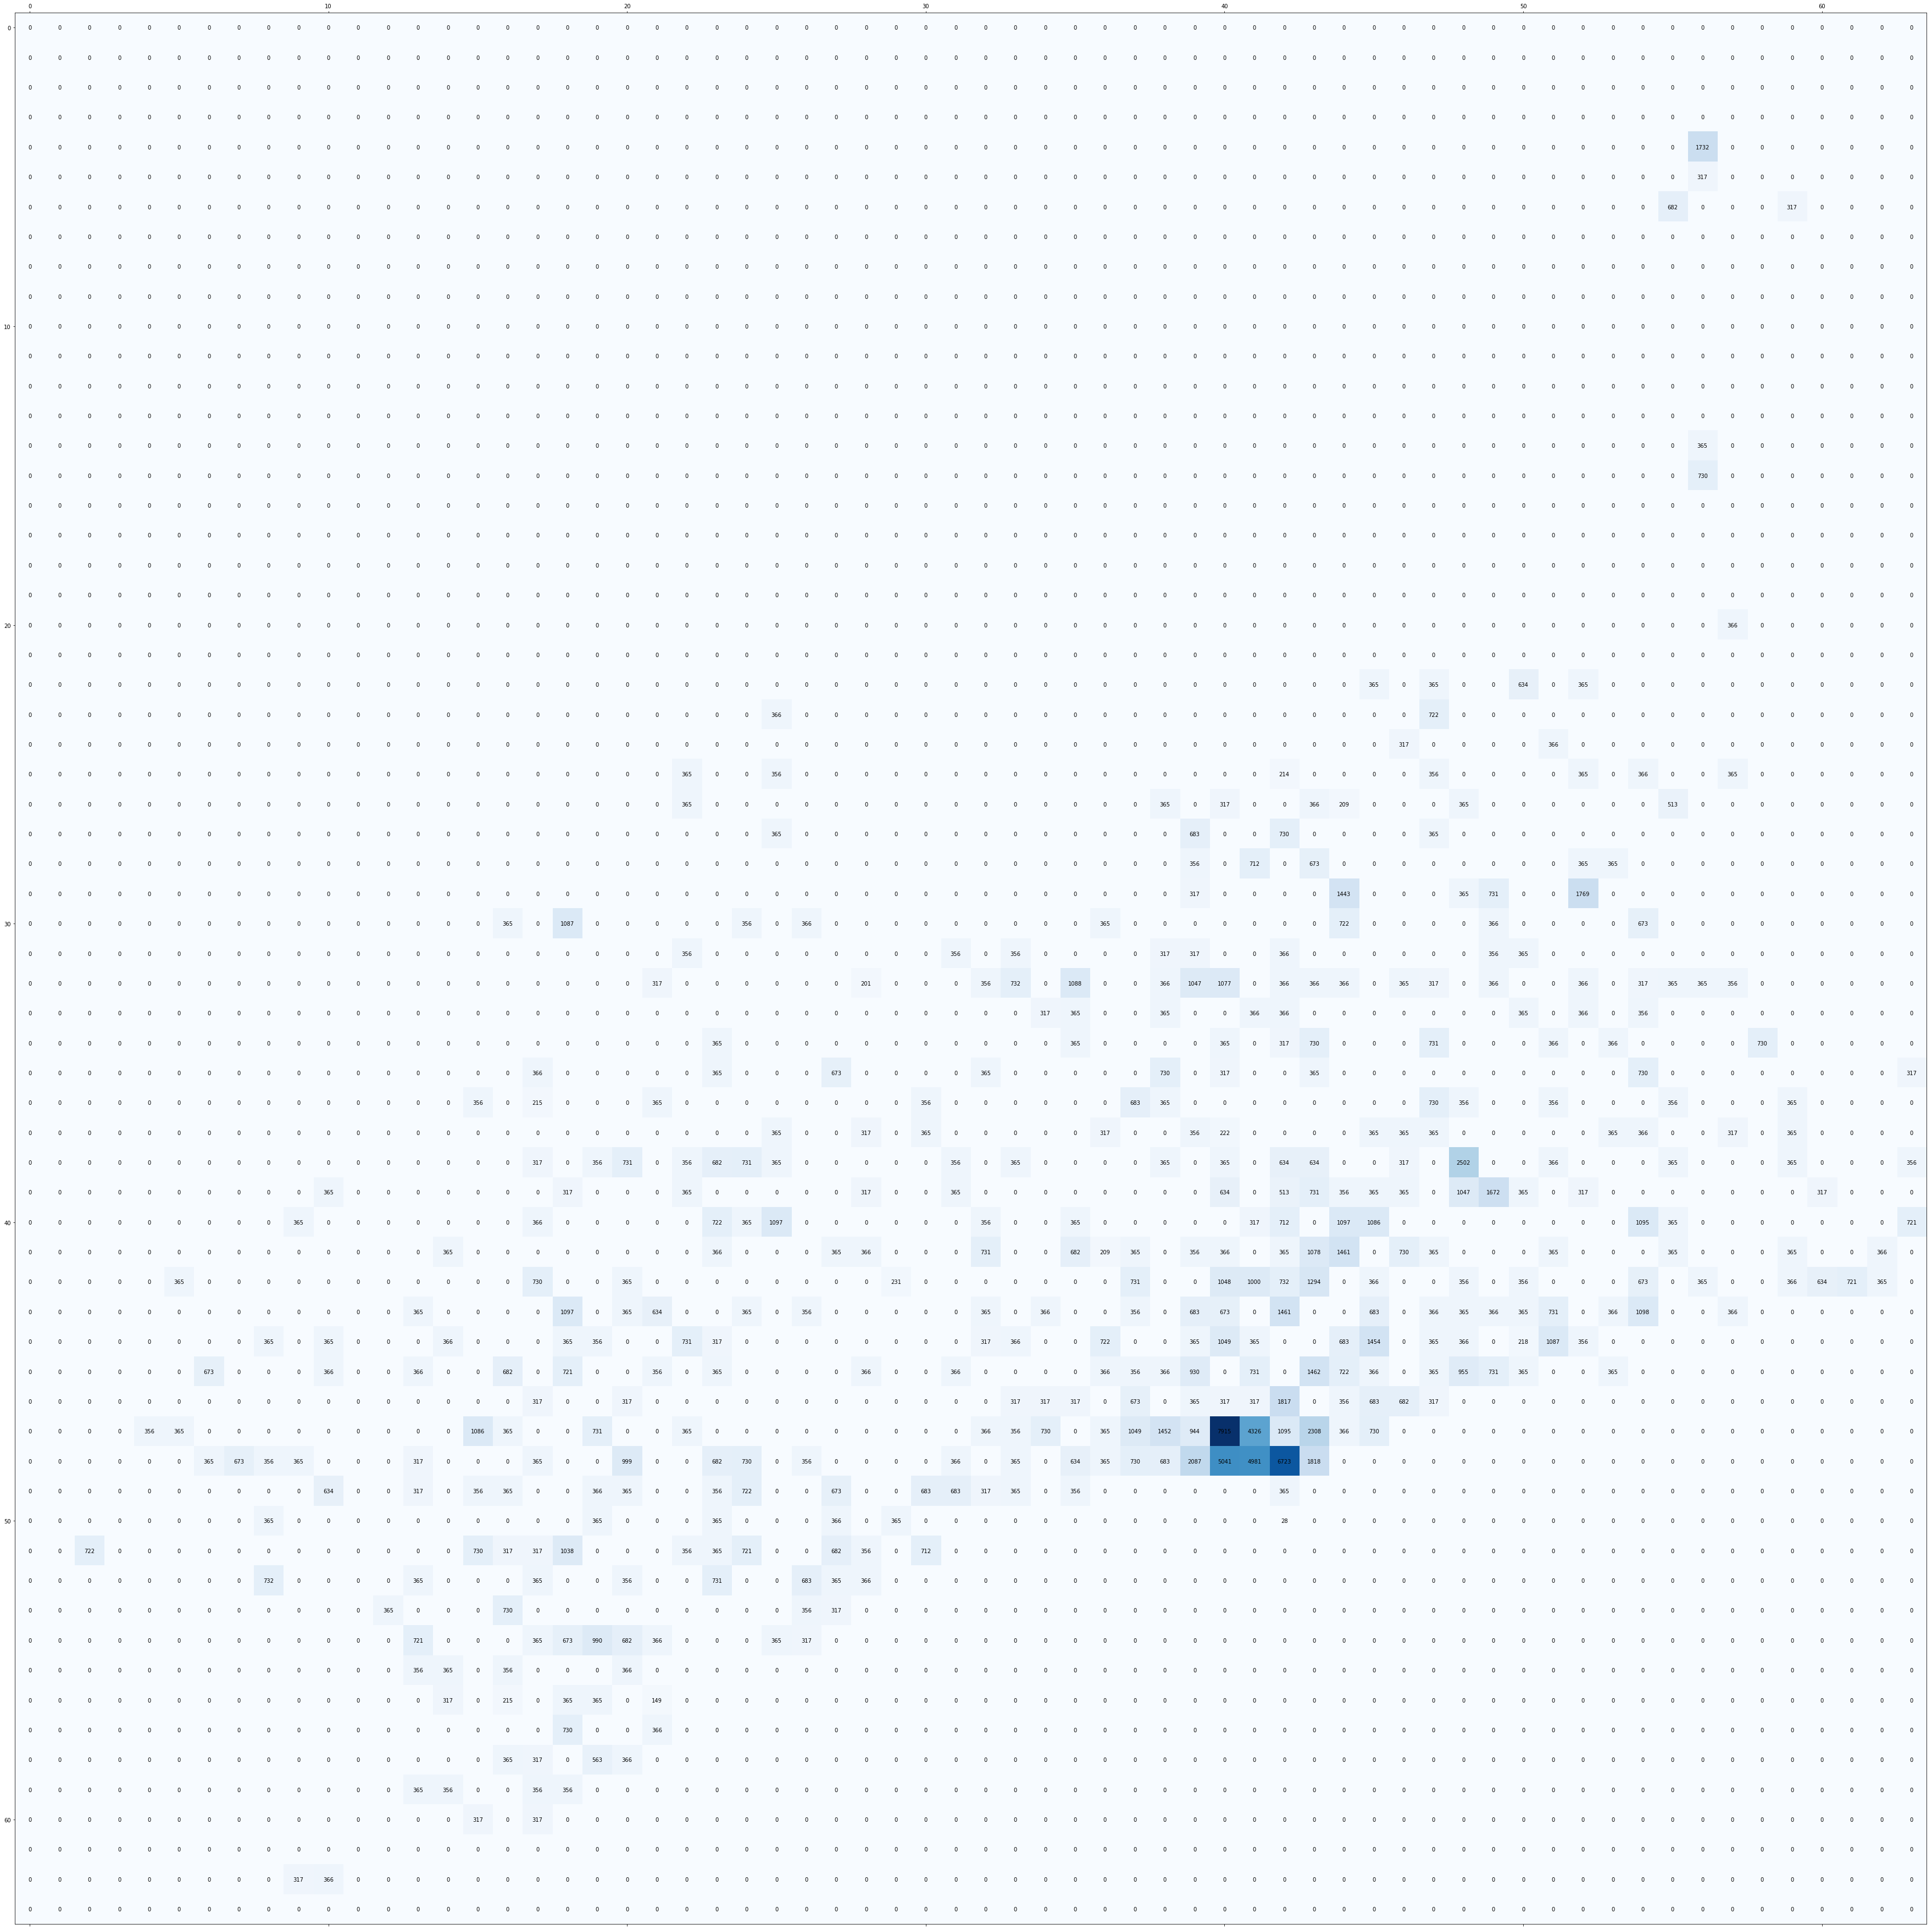

In [25]:
fig, ax = plt.subplots()
fig.set_figheight(64)
fig.set_figwidth(64)

ax.matshow(rank_matrix2, cmap=plt.cm.Blues)

for i in range(64):
    for j in range(64):
        c = rank_matrix2[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
fig.savefig('test.pdf', bbox_inches='tight')

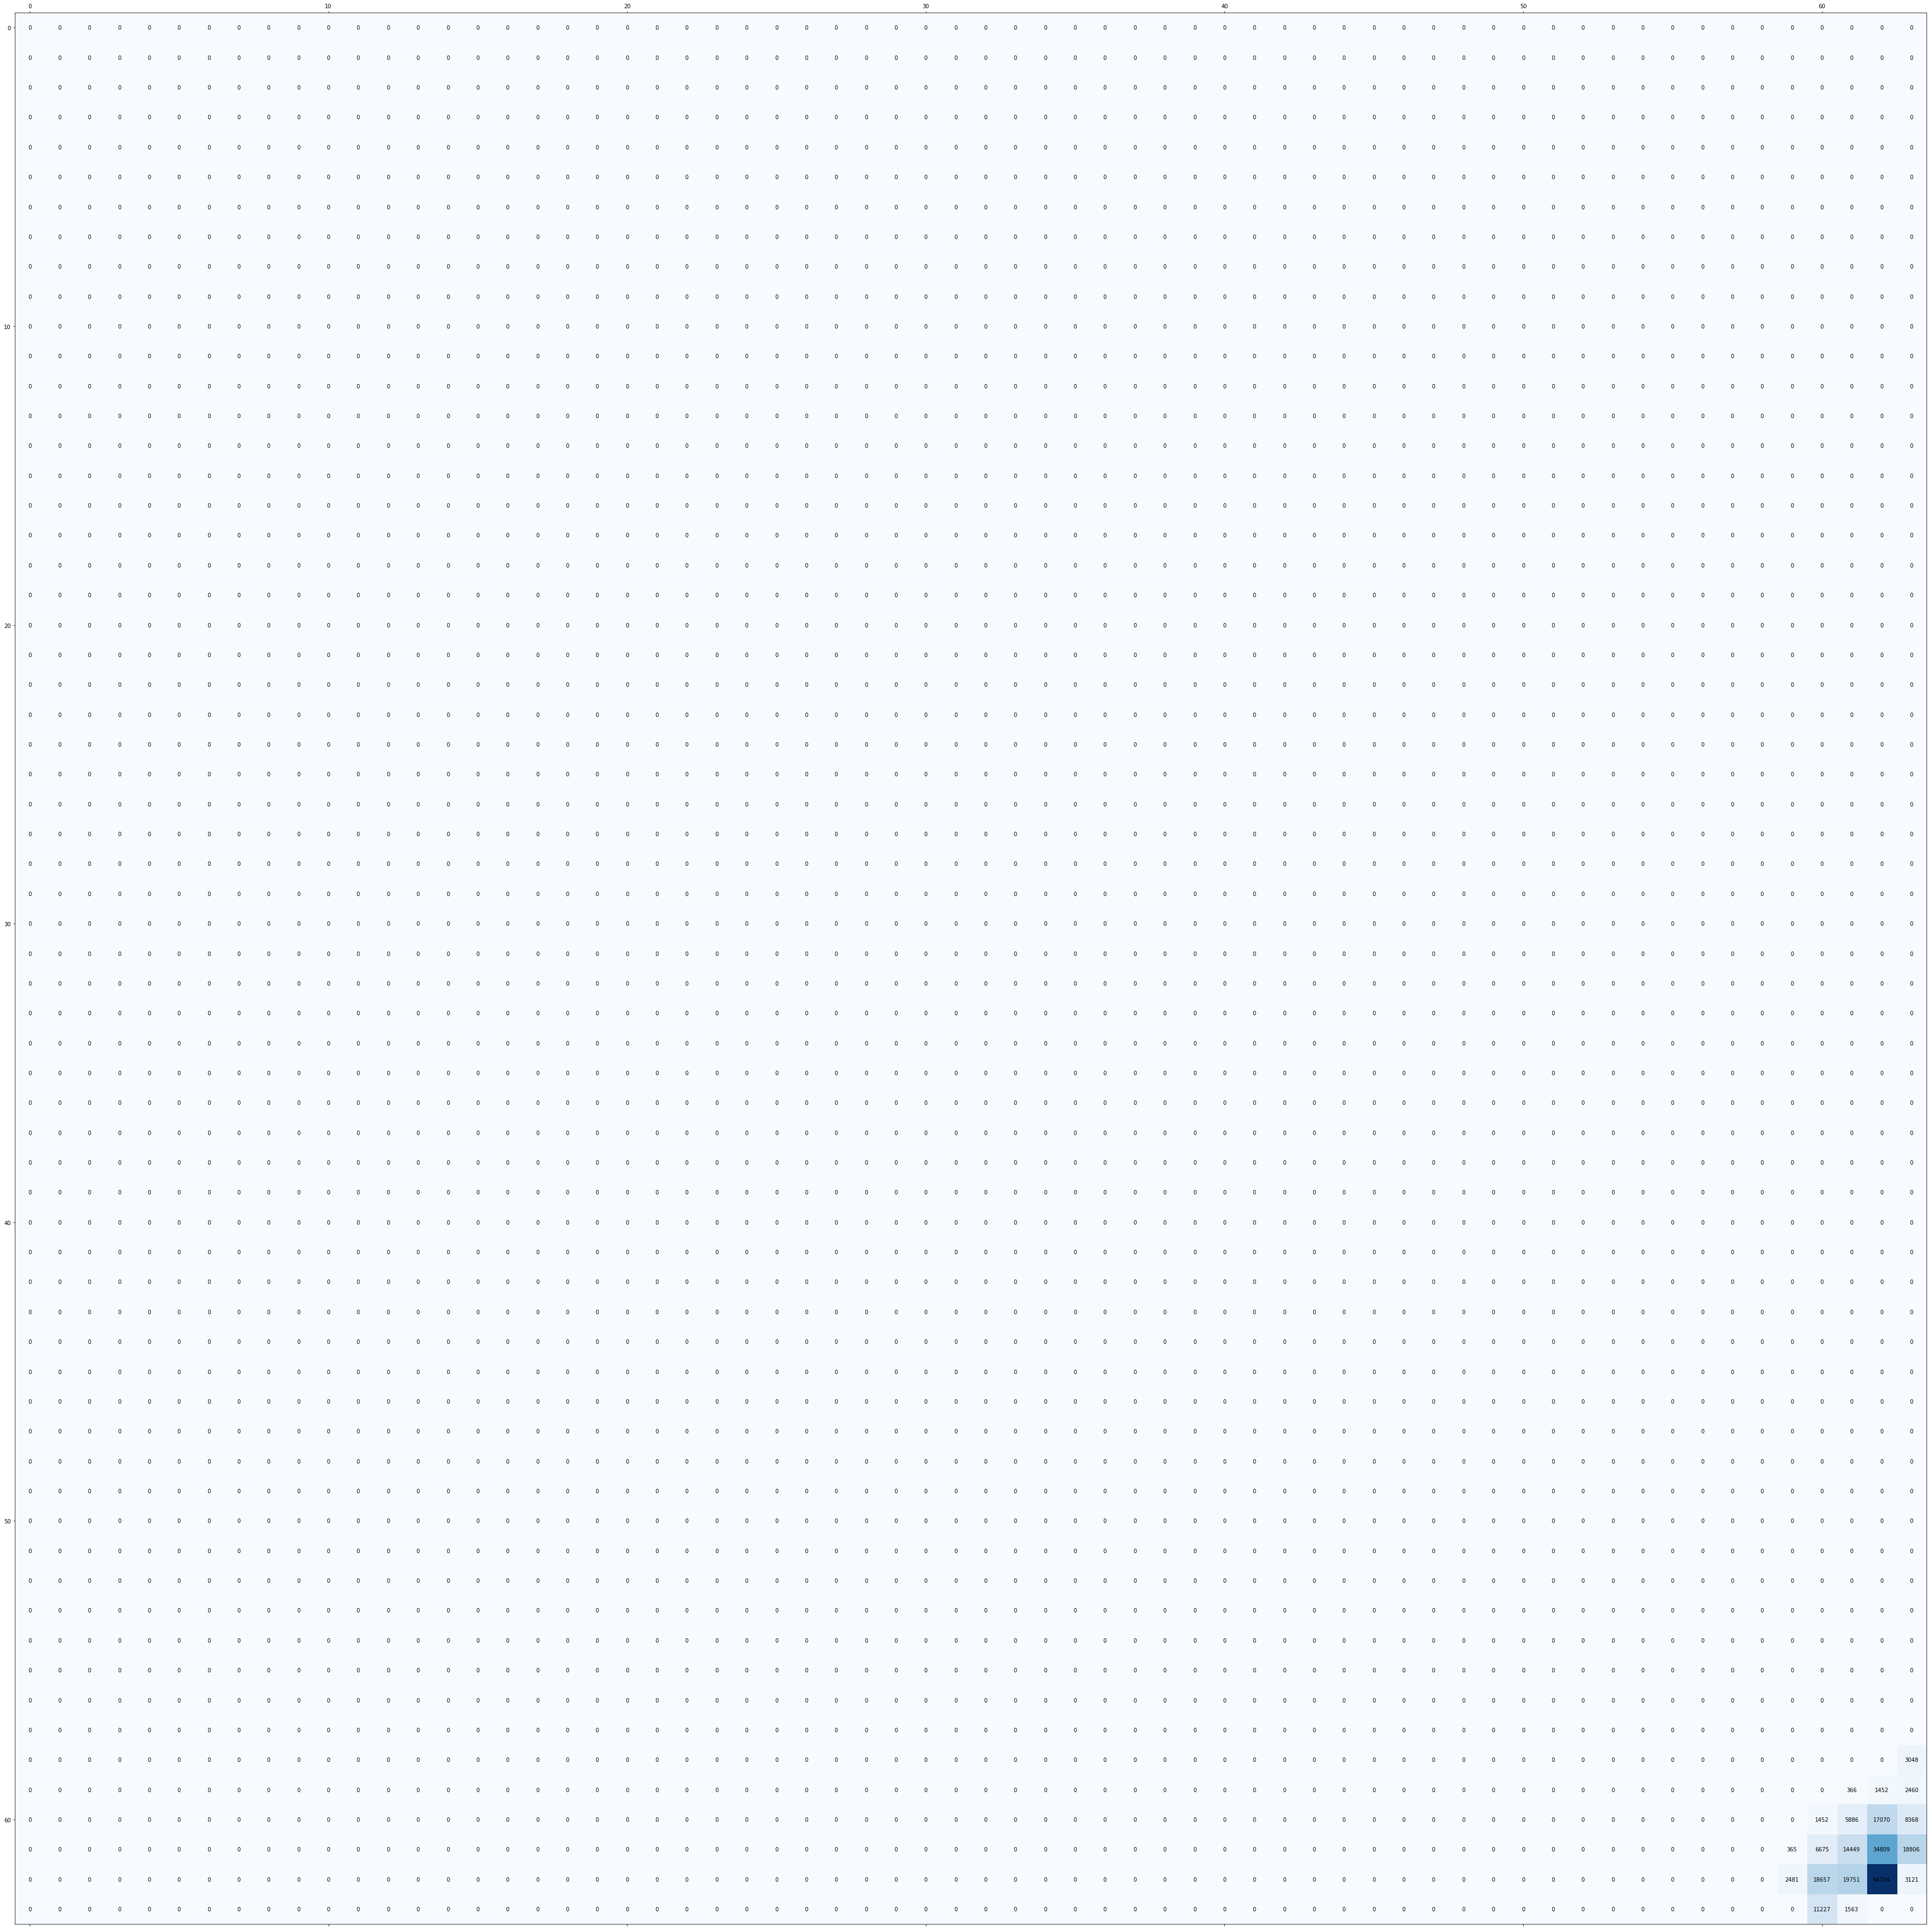

In [52]:
fig, ax = plt.subplots()
fig.set_figheight(64)
fig.set_figwidth(64)

ax.matshow(rank_matrix2, cmap=plt.cm.Blues)

for i in range(64):
    for j in range(64):
        c = rank_matrix2[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
fig.savefig('test.pdf', bbox_inches='tight')

In [12]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D
from keras.layers.core import Layer, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers import TimeDistributed, LSTM
from keras.utils import plot_model

input_nn = Input(X2_training.shape[1:])
conv1_1 = TimeDistributed(Conv2D(64, (2,2), padding = 'same', activation='relu'))(input_nn)
conv1_2 = TimeDistributed(GlobalAveragePooling2D())(conv1_1)
dropout_1 = Dropout(0.5)(conv1_2)
lstm1_2 = LSTM(1024, activation='relu', return_sequences=False)(dropout_1)
dense_1 = Dense(512, activation='relu')(lstm1_2)
output_nn = Dense(4096, activation='linear')(dense_1)

lstmtest = Model(inputs=input_nn, outputs=output_nn)
lstmtest.summary()

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 64, 64, 1)      0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 64, 64, 64)     320       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              4460544   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              2101248   
Total para

In [110]:
plot_model(lstmtest, to_file='lstm_test.png', show_shapes=True, show_layer_names=True)

In [13]:
from keras import backend as K
def coeff_determination(y_true,y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1-SS_res/(SS_tot+K.epsilon()))
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

lstmtest.compile(loss=root_mean_squared_error,optimizer="adam",metrics=[coeff_determination,'mape','mae'])

W1129 13:30:04.605296 140735995704192 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [33]:
#Entrenamiento con 2
epochs = 10
batch_size = 32
history_1 = lstmtest.fit(X1_training, Y1_training, batch_size=batch_size, epochs=epochs, verbose=2,validation_data=(X1_test,Y1_test))

Train on 3147 samples, validate on 1347 samples
Epoch 1/10
 - 5s - loss: 0.2303 - coeff_determination: -1.8948e-01 - mean_absolute_percentage_error: 6155375.7711 - mean_absolute_error: 0.0099 - val_loss: 0.3017 - val_coeff_determination: 0.8471 - val_mean_absolute_percentage_error: 122044986.7498 - val_mean_absolute_error: 0.1332
Epoch 2/10
 - 2s - loss: 0.0551 - coeff_determination: 0.9312 - mean_absolute_percentage_error: 6931724.2943 - mean_absolute_error: 0.0079 - val_loss: 0.1967 - val_coeff_determination: 0.9316 - val_mean_absolute_percentage_error: 16141957.7639 - val_mean_absolute_error: 0.0250
Epoch 3/10
 - 2s - loss: 0.0449 - coeff_determination: 0.9504 - mean_absolute_percentage_error: 2914756.7037 - mean_absolute_error: 0.0037 - val_loss: 0.2206 - val_coeff_determination: 0.9159 - val_mean_absolute_percentage_error: 26506907.7491 - val_mean_absolute_error: 0.0363
Epoch 4/10
 - 2s - loss: 0.0415 - coeff_determination: 0.9648 - mean_absolute_percentage_error: 3036814.2267 - m

In [14]:
#Entrenando con 7
epochs = 10
batch_size = 32
history_1 = lstmtest.fit(X2_training, Y2_training, batch_size=batch_size, epochs=epochs, verbose=2,validation_data=(X2_test,Y2_test))

W1129 13:32:12.048547 140735995704192 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1129 13:32:12.629871 140735995704192 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3150 samples, validate on 1350 samples
Epoch 1/10
 - 58s - loss: 0.0621 - coeff_determination: 0.3798 - mean_absolute_percentage_error: 5155674.4716 - mean_absolute_error: 0.0080 - val_loss: 0.2348 - val_coeff_determination: -1.1807e-01 - val_mean_absolute_percentage_error: 39133294.7733 - val_mean_absolute_error: 0.0674
Epoch 2/10


KeyboardInterrupt: 

In [20]:
decoded_grids_1 = lstmtest.predict(X1_test)

In [ ]:
#Métrica
List_1_pred = []
List_1_test = []

for i in range(len(Y1_test)):
    m1_p = np.squeeze(np.asarray(decoded_grids_1[i])).flatten().astype(int)
    m1_t = np.squeeze(np.asarray(Y1_test[i])).flatten().astype(int)
    for j in range (len(m1_p)):
        if m1_p[j] >0:
            m1_p[j] = 1
        if m1_t[j] >0:
            m1_t[j] = 1
            
    List_1_pred.append(m1_p)
    List_1_test.append(m1_t)

Array_1_pred = np.concatenate(List_1_pred)
Array_1_test = np.concatenate(List_1_test)


In [ ]:
#Métrica
from sklearn.metrics import precision_recall_curve,average_precision_score,roc_curve,auc
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return fpr, tpr, threshold
    
# calculate the fpr and tpr for all thresholds of the classification
def plot_pr_curve(y_test, preds):
    precision, recall, thresholds= precision_recall_curve(y_test, preds)
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall')
    plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % pr_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0.1, 0.1],'g--')
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    return precision, recall, thresholds

In [ ]:
#Métrica
List_fpr = []
List_tpr = []
List_threshold = []
List_roc_auc = []
List_precision = []
List_recall = []
List_thresholds = []
List_pr_auc = []
for i in range(6):
    fpr, tpr, threshold = roc_curve(vars()['Array_' + str(i+1) + "_test"],vars()['Array_' + str(i+1) + "_pred"])
    precision, recall, thresholds= precision_recall_curve(vars()['Array_' + str(i+1) + "_test"],vars()['Array_' + str(i+1) + "_pred"])
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    List_fpr.append(fpr)
    List_tpr.append(tpr)
    List_threshold.append(threshold)
    List_roc_auc.append(roc_auc)
    List_precision.append(precision)
    List_recall.append(recall)
    List_thresholds.append(thresholds)
    List_pr_auc.append(pr_auc)

In [ ]:
#Métrica
f = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(List_fpr[0], List_tpr[0], 'tab:blue', label = 'AUC1 = %0.4f' % List_roc_auc[0])
plt.legend(loc = 'lower right')
plt.show()
f.savefig('mx_roc.pdf', bbox_inches='tight')

In [ ]:
#Métrica
f = plt.figure()
plt.title('Precision-Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.plot([0, 1], [0.1, 0.1],'g--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(List_recall[0], List_precision[0], 'tab:blue', label = 'AUC1 = %0.4f' % List_pr_auc[0])
plt.legend(loc = 'lower left')
plt.show()
f.savefig('mx_pr.pdf', bbox_inches='tight')